## Import libraries

In [80]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from warnings import filterwarnings
from tqdm.notebook import tqdm_notebook
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Rescaling, Input

In [2]:
filterwarnings('ignore')
tf.__version__

'2.15.0'

## Familizarization with the dataset

In [3]:
def show_random_images(from_dir = 'train'):
    DATA_PATH = r"/kaggle/input/emotion-detection-fer"
    DIR_PATH = os.path.join(DATA_PATH, from_dir)
    available_classes = os.listdir(DIR_PATH)
    
    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (7, 7))
    for row in range(3):
        for col in range(3):
            random_class = random.choice(available_classes)
            class_path = os.path.join(DIR_PATH, random_class)
            images_in_dir = os.listdir(class_path)
            random_img = random.choice(images_in_dir)
            img = mpimg.imread(os.path.join(class_path, random_img))
            axes[row][col].imshow(img, cmap = 'gray')
            axes[row][col].set_title(random_class)
            axes[row][col].axis('off')
            plt.tight_layout()

### Visualize train datasets

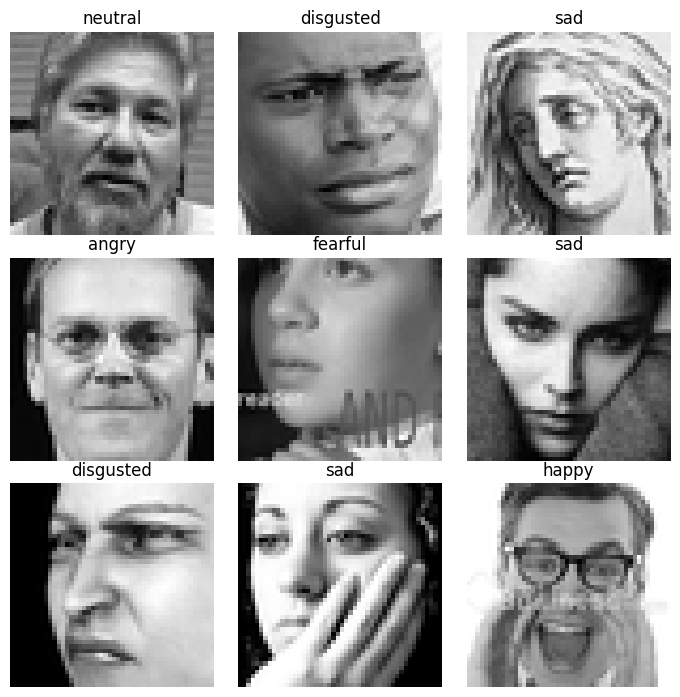

In [4]:
show_random_images(from_dir = 'train')

### Visualize test data

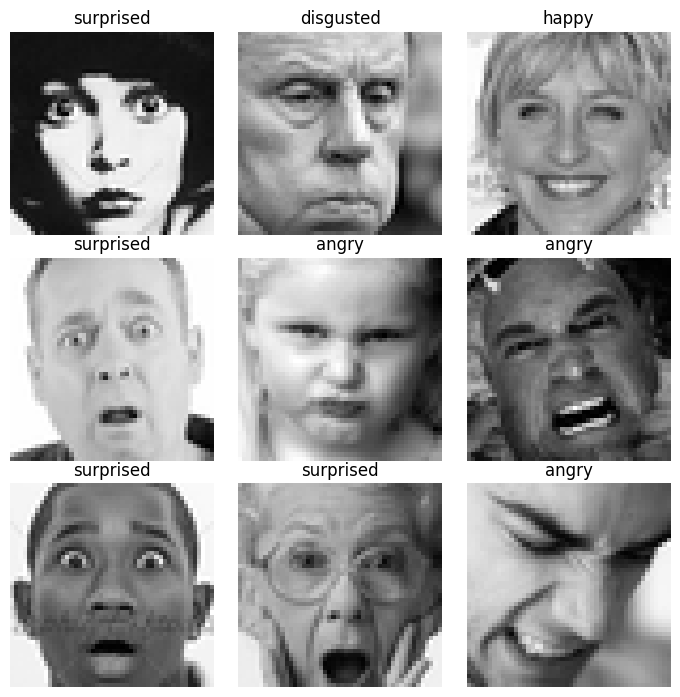

In [6]:
show_random_images(from_dir = 'test')

## Class distribution

In [100]:
label_dict = {
    0: 'angry',
    1: 'disgusted',
    2: 'fearful',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprised'
}

label_dict_2 = {  
    'angry': 0,
    'disgusted': 1,
    'fearful': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprised': 6
}

In [8]:
def plot_class_distribution(of = 'train'):
    DATA_PATH = r"/kaggle/input/emotion-detection-fer"
    DIR_PATH = os.path.join(DATA_PATH, of)
    available_classes = os.listdir(DIR_PATH)
    count_dict = {}
    for label in tqdm_notebook(available_classes):
        n_images = len(os.listdir(os.path.join(DIR_PATH, label)))
        count_dict[label] = n_images
        
    sns.barplot(x = list(count_dict.keys()), y = list(count_dict.values()))
    plt.title(f"{of.title()} class distribution")
    plt.xlabel("Classes")
    plt.ylabel("Total samples")
    plt.show()


### Train set 

  0%|          | 0/7 [00:00<?, ?it/s]

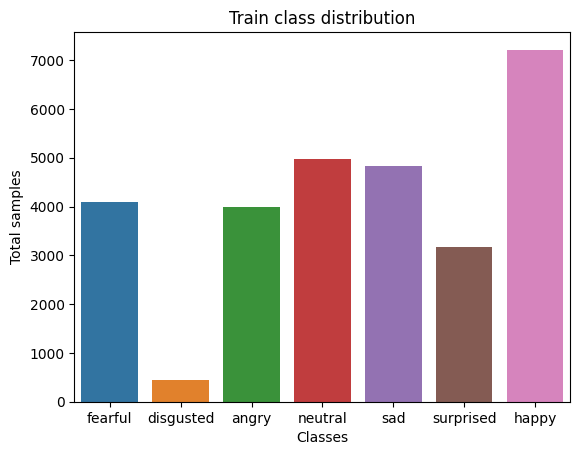

In [9]:
plot_class_distribution(of = 'train')

### Test set

  0%|          | 0/7 [00:00<?, ?it/s]

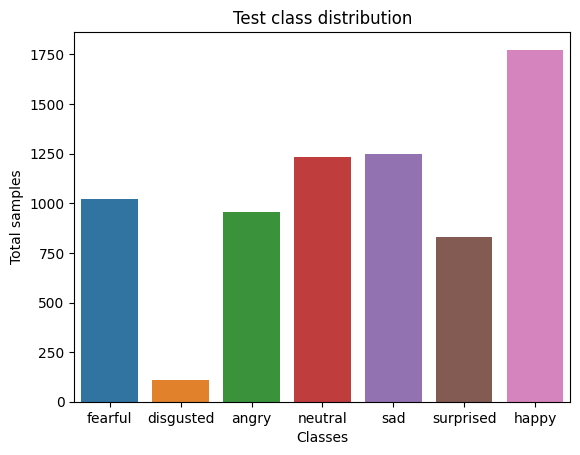

In [10]:
plot_class_distribution(of = 'test')

## Load data

### Train data

In [11]:
train_data = image_dataset_from_directory(
    directory = "/kaggle/input/emotion-detection-fer/train",
    batch_size = 32,
    image_size = (48, 48),
    color_mode = 'grayscale'
)

Found 28709 files belonging to 7 classes.


### Test data

In [12]:
test_data = image_dataset_from_directory(
    directory = "/kaggle/input/emotion-detection-fer/test",
    batch_size = 32,
    image_size = (48, 48),
    color_mode = 'grayscale'
)

Found 7178 files belonging to 7 classes.


## Modelling experiments

### Custom Conv2D model

In [17]:
def model_ckpt(name):
    return ModelCheckpoint(
        filepath = f"/kaggle/working/{name}.keras",
        save_best_only = True,
        monitor = 'val_accuracy',
        verbose = 1
    )

In [20]:
inputs = Input(shape = (48, 48, 1))
x = Rescaling(scale = 1/255.)(inputs)
x = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(x)
x = MaxPool2D(pool_size = (2, 2), padding = 'same')(x)
x = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(x)
x = MaxPool2D(pool_size = (3, 3), padding = 'valid')(x)
x = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(x)
x = MaxPool2D(pool_size = (2, 2), padding = 'same')(x)
x = Flatten()(x)
x = Dropout(rate = 0.5)(x)
x = Dense(units = 128, activation = 'relu')(x)
outputs = Dense(units = len(labels), activation = "softmax")(x)

model = Model(inputs = inputs, outputs = outputs)

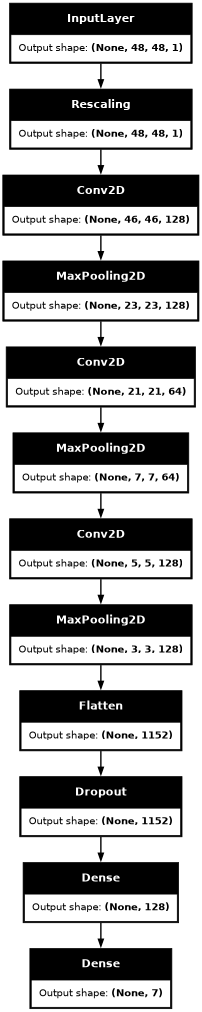

In [21]:
tf.keras.utils.plot_model(model, dpi = 50, show_shapes=True)

In [22]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [23]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,415 (1.13 MB)

 Trainable params: 297,415 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model_hist = model.fit(train_data, validation_data = test_data, callbacks = [model_ckpt("model_conv2d")], epochs = 20)

Epoch 1/20
 12/898 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.2374 - loss: 1.8697

W0000 00:00:1713025684.482786      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2594 - loss: 1.7915

W0000 00:00:1713025701.854469      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713025702.621815      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.40401, saving model to /kaggle/working/model_conv2d.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.2594 - loss: 1.7914 - val_accuracy: 0.4040 - val_loss: 1.5359
Epoch 2/20
895/898 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4090 - loss: 1.5205
Epoch 2: val_accuracy improved from 0.40401 to 0.47116, saving model to /kaggle/working/model_conv2d.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.4091 - loss: 1.5203 - val_accuracy: 0.4712 - val_loss: 1.3828
Epoch 3/20
893/898 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4655 - loss: 1.3839
Epoch 3: val_accuracy improved from 0.47116 to 0.50543, saving model to /kaggle/working/model_conv2d.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.4655 - loss: 1.3838 - val_accuracy: 0.5054 - val_loss: 1.2948
Epoch 4/20
896/898 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4942 - loss: 1.3104
Epoch 4: val_accuracy improved from 0.50543 to 0.52090, saving 

In [55]:
def plot_model_performance(hist_obj):
    epochs = hist_obj.epoch
    hist = hist_obj.history
    plt.figure(figsize = (10, 4))
    plt.subplot(1, 2, 1)
    sns.lineplot(x = epochs, y = hist['loss'], label = 'train_loss')
    sns.lineplot(x = epochs, y = hist['val_loss'], label = 'test_loss')
    plt.grid(True)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(0, epochs[-1], 2))
    plt.legend()
    plt.subplot(1, 2, 2)
    sns.lineplot(x = epochs, y = hist['accuracy'], label = 'train_accuracy')
    sns.lineplot(x = epochs, y = hist['val_accuracy'], label = 'test_accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.xticks(np.arange(0, epochs[-1], 2))
    plt.legend()
    
    plt.suptitle("Model performance")
    plt.tight_layout()
    

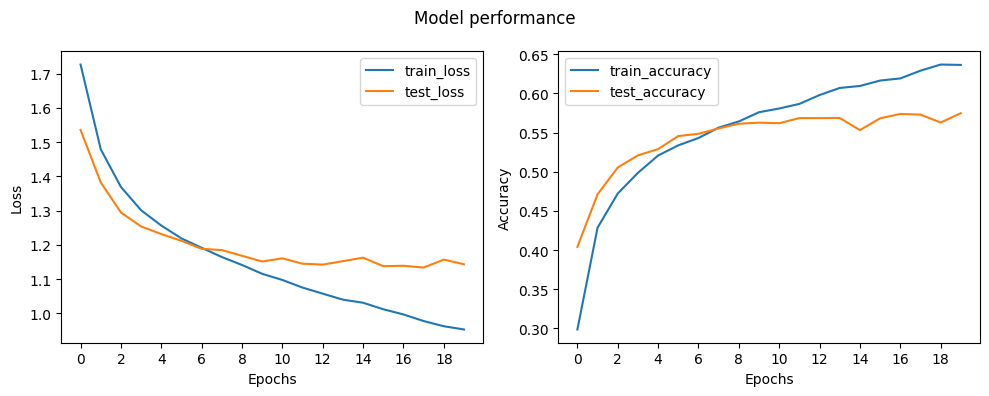

In [47]:
plot_model_performance(model_hist)

### Transfer Learning (EfficientV2B2)

In [31]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 3,
    restore_best_weights = True
)

In [4]:
train_data_new = image_dataset_from_directory(
    directory = "/kaggle/input/emotion-detection-fer/train",
    label_mode = 'categorical',
    image_size = (64, 64),
    batch_size = 32
)

Found 28709 files belonging to 7 classes.


In [5]:
test_data_new = image_dataset_from_directory(
    directory = "/kaggle/input/emotion-detection-fer/test",
    label_mode = 'categorical',
    image_size = (64, 64),
    batch_size = 32
)

Found 7178 files belonging to 7 classes.


In [45]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2, preprocess_input

effnet = EfficientNetV2B2(include_top = False, input_shape = (64, 64, 3), pooling = 'max')

# for layer in effnet.layers[:-10]:
#     layer.trainable = False

In [46]:
inputs = Input(shape = (64,64,3))
x = preprocess_input(inputs)
x = effnet(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5)(x)
outputs = Dense(units = 7, activation = 'softmax')(x)

effnet_model = Model(inputs, outputs)

In [48]:
effnet_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00015),
    metrics = ['accuracy']
)

In [49]:
effnet_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 1408)           │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,967,141 (34.21 MB)

 Trainable params: 8,884,853 (33.89 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [50]:
effnet_model_hist = effnet_model.fit(train_data_new, validation_data = test_data_new, callbacks = [early_stop, model_ckpt("effnet_model")], epochs = 20)

Epoch 1/20
  3/898 ━━━━━━━━━━━━━━━━━━━━ 54s 61ms/step - accuracy: 0.1285 - loss: 2.8243   

W0000 00:00:1713068336.689937      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2103 - loss: 2.0737

W0000 00:00:1713068440.366823      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713068449.395603      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.40541, saving model to /kaggle/working/effnet_model.keras


W0000 00:00:1713068455.398270      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


898/898 ━━━━━━━━━━━━━━━━━━━━ 245s 134ms/step - accuracy: 0.2103 - loss: 2.0735 - val_accuracy: 0.4054 - val_loss: 1.5686
Epoch 2/20
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3705 - loss: 1.6207
Epoch 2: val_accuracy improved from 0.40541 to 0.49122, saving model to /kaggle/working/effnet_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.3706 - loss: 1.6206 - val_accuracy: 0.4912 - val_loss: 1.3536
Epoch 3/20
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4584 - loss: 1.4269
Epoch 3: val_accuracy improved from 0.49122 to 0.54110, saving model to /kaggle/working/effnet_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.4585 - loss: 1.4268 - val_accuracy: 0.5411 - val_loss: 1.2324
Epoch 4/20
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5187 - loss: 1.2871
Epoch 4: val_accuracy improved from 0.54110 to 0.57760, saving model to /kaggle/working/effnet_model.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.51

In [57]:
effnet_loaded_model = tf.keras.models.load_model("effnet_model.keras")
effnet_loaded_model.evaluate(test_data_new)

 11/225 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6653 - loss: 1.2734

W0000 00:00:1713069213.908877      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.6497 - loss: 1.3920


W0000 00:00:1713069219.934714      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1.4354405403137207, 0.6482307314872742]

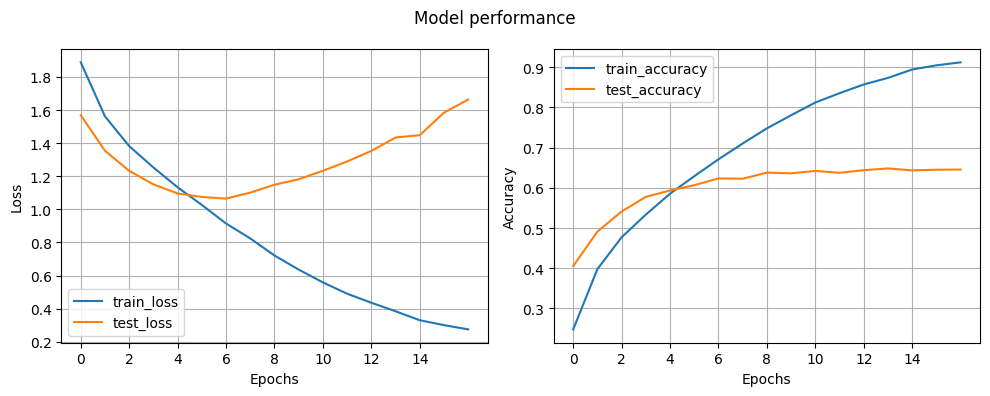

In [56]:
plot_model_performance(effnet_model_hist)